In [78]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm

In [65]:
DATA_DIR="../data/"
PROTEOME_NAME="UP000005640_9606"

### Load scores

Per-protein per-residue scores for each metric.

In [66]:
# load Neff scores
with open(os.path.join(DATA_DIR, f"{PROTEOME_NAME}_neff_fast.json")) as f:
    neff = json.load(f)
    neff = {p:torch.tensor(xs) for p,xs in neff.items()}
print(len(neff), "neff scores loaded")

16252 neff scores loaded


In [67]:
# load SETH scores
with open(os.path.join(DATA_DIR, "Human_SETH_preds.txt")) as f:
    seth = {}
    lines = f.readlines()
    for hdr,scores in zip(lines[::2],lines[1::2]):
        hdrid=hdr.split("|")[1]
        score=torch.tensor([float(s) for s in scores.split(", ")])
        seth[hdrid]=score
print(len(seth), "SETH scores loaded")

20352 SETH scores loaded


In [68]:
# load pLDDT scores
with open(os.path.join(DATA_DIR, f"{PROTEOME_NAME}_HUMAN_v3_plddts_fltrd.json")) as f:
    plddt = json.load(f)
    plddt = {p:torch.tensor(xs) for p,xs in plddt.items()}
print(len(plddt), "neff scores loaded")

20296 neff scores loaded


### Find consistent proteins

Only correlate metrics for which we have data for all proteins. Data means that every dataset contains the protein and the proteins have the same lengths across all datasets.

In [69]:
shared_ids = set(neff) & set(seth) & set(plddt)
print("found", len(shared_ids), "ids that are present in all datasets")

found 15933 ids that are present in all datasets


In [81]:
lenagree_ids = []
for protid in shared_ids:
    if len(neff[protid]) == len(seth[protid]) == len(plddt[protid]):
        lenagree_ids.append(protid)
print("found", len(lenagree_ids), "proteins with agreeing langths")

found 15892 proteins with agreeing langths


In [82]:
# only retain scores that are present in all 3 datasets for convinience
ids = lenagree_ids
neff = {p:xs for p,xs in neff.items() if p in ids}
seth = {p:xs for p,xs in seth.items() if p in ids}
plddt = {p:xs for p,xs in plddt.items() if p in ids}
len(neff),len(seth),len(plddt),len(ids)

(15892, 15892, 15892, 15892)

### Analysis

In [90]:
corrs = {}
for protid in tqdm(ids,desc="calculating pairwise correlations"):
    scores = torch.stack((neff[protid], seth[protid], plddt[protid]))
    corrs[protid] = torch.corrcoef(scores)

calculating pairwise correlations: 100%|█| 15892/15892 [00:00<00:00, 20165.53it/


Text(0.5, 1.0, 'scores for Q9H2J1')

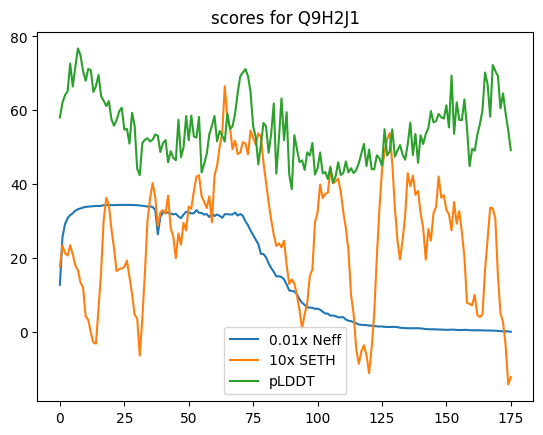

In [93]:
testid = list(ids)[100]
plt.plot(.01*neff[testid],label="0.01x Neff")
plt.plot(10.*seth[testid],label="10x SETH")
plt.plot(plddt[testid],label="pLDDT")
plt.legend()
plt.title("scores for %s" % testid)

Text(0.5, 1.0, 'correlation matrix for Q9H2J1')

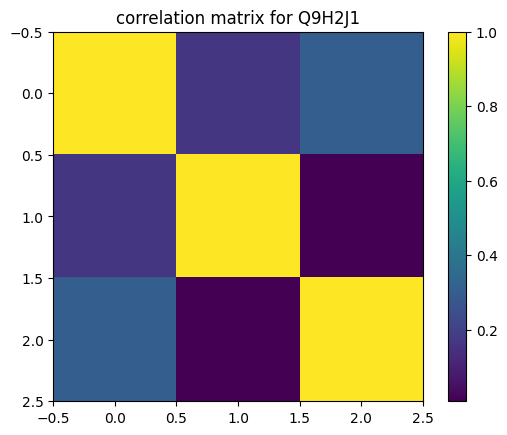

In [97]:
plt.imshow(corrs[testid])
plt.colorbar()
plt.title("correlation matrix for %s" % testid)